In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.transforms as transforms
from rewards import *
from utils import *
from strategies import *
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm import tqdm

In [39]:
# plot parameters
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

In [40]:
# algo names for legend
algonames = {'UnknownDistribution': 'Known reward',
             'Monotone': 'Non-decreasing',
             'NaiveStrategy': 'Naive',
             'Bandit': 'Bandit'
            }

# Expe 1: linear reward

In [47]:
expe = 1

# problem parameters
rew = affineReward(dirCoef=1, originOrd=-0.5)
maxride = 3
ridedistribution = uniformRide(maxval=maxride)
rate = 1
beta, L = rew.holder(maxride=maxride)

t = np.linspace(0, maxride, 10000)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))

# simulation parameters
ninstances = 50
horizons = np.geomspace(1000, 1000000, 20, dtype=int)
noise = uniformNoise(1)

scores = {}
algos = {}
for horizon in horizons:
    algos[horizon] = [UnknownDistribution_RBT(rew, maxrew=maxrew, delta=1/horizon, minrew=minrew),
                     Bandit_RBT(horizon=horizon, L=L, beta=beta, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var, kappa=0.5),
                     Monotone(horizon=horizon, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var),
                     NaiveStrategy()
                     ]
    for algo in algos[horizon]:
        if algo.name=="Monotone":
            algo.sigma /= 60

In [48]:
# load previous results
scores = {}
for horizon in horizons:
    scores[horizon] = {}
    for algo in algos[horizon]:
        try:
            scores[horizon][algo.name] = list(np.load('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name)))
        except FileNotFoundError:
            scores[horizon][algo.name] = []

In [6]:
try:
    for horizon in horizons:
        for algo in algos[horizon]:
            if ninstances>len(scores[horizon][algo.name]):
                for _ in tqdm(range(ninstances-len(scores[horizon][algo.name])), desc="{} with horizon {}".format(algo.name, horizon)):
                    algo.reset()
                    r = simu(rew, ridedistribution, algo, rate=1, horizon=horizon)
                    scores[horizon][algo.name].append(r)

                # also save the scores if we ran the whole algorithm without interrupting
                np.save('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name), scores[horizon][algo.name])

except KeyboardInterrupt:
    # save in case of interruption
    print('Number of tries ran for {}, horizon={} : {}'.format(algo.name, horizon, len(scores[horizon][algo.name])))
    np.save('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name), scores[horizon][algo.name])


UnknownDistribution with horizon 1000000: 100%|██████████| 280/280 [8:11:28<00:00, 105.28s/it]


## Plot regret

In [23]:
samples = ridedistribution.simu(int(1e8))
rewards = rew.eval(samples)
cstar = profOpt(rewards, samples, rate=rate, precision=1e-15)

In [49]:
#confidence = {}
regret = {}
for algo in algos[horizons[0]]:
    regret[algo.name] = np.zeros_like(horizons, dtype=float)
    confidence[algo.name] = np.zeros_like(horizons, dtype=float)
    for i, horizon in enumerate(horizons):
        regret[algo.name][i] = np.maximum(0, cstar*horizon - np.mean(scores[horizon][algo.name][:ninstances]))
        #confidence[algo.name][i] = 1.96*np.std(scores[horizon][algo.name][:ninstances])/np.sqrt(len(scores[horizon][algo.name][:ninstances])) # 95% confidence interval

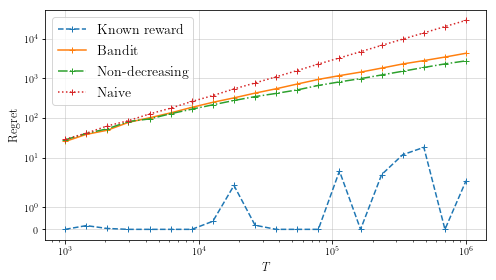

In [50]:
# plot evolution of regret
fig = plt.figure(figsize=(7,4))
ls = ['--', '-', '-.', ':']
for i,algo in enumerate(algos[horizons[0]]):
    name = algonames.get(algo.name,algo.name)
    plt.plot(horizons, regret[algo.name], ls[i], label=name, marker='+')
    #plt.fill_between(horizons, (regret[algo.name]-confidence[algo.name]), (regret[algo.name]+confidence[algo.name]), color='b', alpha=.1)
plt.xlabel('$T$', fontsize=12)
plt.xscale('log')
plt.yscale('symlog')
plt.ylabel('Regret', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=14, loc='upper left').set_zorder(1.5)
plt.tight_layout()
plt.savefig('figures/regret_{}_{}_{}_{}.pgf'.format(rew.name, ridedistribution.name, noise.name, expe))
plt.show()

UnknownDistribution has almost no regret here because the profitability function has good regularities, which leads to a way smaller regret than the minimax $\sqrt{T}$ one.
It should actually scale in $\log(T)$ because of margin constraints here.

# Expe 2: concave reward

In [51]:
expe = 2

# problem parameters
rew = concaveReward2(a=1, b=0.2, c=0.3)
maxride = 3
ridedistribution = uniformRide(maxval=maxride)
rate = 1
beta, L = rew.holder(maxride=maxride)

t = np.linspace(0, maxride, 10000)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))

# simulation parameters
ninstances = 50
horizons = np.geomspace(1000, 1000000, 20, dtype=int)
noise = gaussianNoise(0.1)

scores = {}
algos = {}
for horizon in horizons:
    algos[horizon] = [UnknownDistribution_RBT(rew, maxrew=maxrew, delta=1/horizon, minrew=minrew),
                     Bandit_RBT(horizon=horizon, L=L, beta=beta, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var, kappa=0.5),
                     NaiveStrategy()
                     ]

In [52]:
# load previous results
scores = {}
for horizon in horizons:
    scores[horizon] = {}
    for algo in algos[horizon]:
        try:
            scores[horizon][algo.name] = list(np.load('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name)))
        except FileNotFoundError:
            scores[horizon][algo.name] = []

In [ ]:
try:
    for horizon in horizons:
        for algo in algos[horizon]:
            if ninstances>len(scores[horizon][algo.name]):
                for _ in tqdm(range(ninstances-len(scores[horizon][algo.name])), desc="{} with horizon {}".format(algo.name, horizon)):
                    algo.reset()
                    r = simu(rew, ridedistribution, algo, rate=1, horizon=horizon)
                    scores[horizon][algo.name].append(r)

                # also save the scores if we ran the whole algorithm without interrupting
                np.save('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name), scores[horizon][algo.name])

except KeyboardInterrupt:
    # save in case of interruption
    print('Number of tries ran for {}, horizon={} : {}'.format(algo.name, horizon, len(scores[horizon][algo.name])))
    np.save('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name), scores[horizon][algo.name])


UnknownDistribution with horizon 1000000:  99%|█████████▉| 140/141 [5:54:50<02:50, 170.41s/it]

## Plot regret

In [53]:
samples = ridedistribution.simu(int(1e8))
rewards = rew.eval(samples)
cstar = profOpt(rewards, samples, rate=rate, precision=1e-15)

In [ ]:

for algo in algos[horizons[0]]:
    regret[algo.name] = np.zeros_like(horizons, dtype=float)
    for i, horizon in enumerate(horizons):
        regret[algo.name][i] = max(0,cstar*horizon - np.mean(scores[horizon][algo.name][:ninstances]))

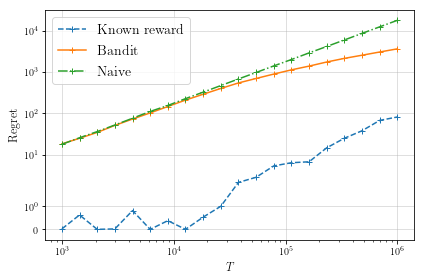

In [54]:
# plot evolution of regret
fig = plt.figure()
ls = ['--', '-', '-.', ':']
for i,algo in enumerate(algos[horizons[0]]):
    name = algonames.get(algo.name,algo.name)
    plt.plot(horizons, regret[algo.name], ls[i], label=name, marker='+')
plt.xlabel('$T$', fontsize=12)
plt.ylabel('Regret', fontsize=12)
plt.xscale('log')
plt.yscale('symlog')
plt.legend(fontsize=14).set_zorder(1.5)
plt.grid(alpha=0.5)
plt.tight_layout()
fig.savefig('figures/regret_{}_{}_{}_{}.pgf'.format(rew.name, ridedistribution.name, noise.name, expe))
plt.show()

# Expe 3: concave reward and discrete ride distribution

In [15]:
expe = 3

# problem parameters
rew = concaveReward2(a=1, b=0.2, c=0.3)
maxride = 3
K = 20
ridedistribution = uniformRide(maxval=maxride, discrete=True, K=K)
rate = 1
beta, L = rew.holder(maxride=maxride)

t = np.linspace(0, maxride, 10000)
maxrew = np.max(rew.eval(t))
minrew = np.min(rew.eval(t))

# simulation parameters
ninstances = 50
horizons = np.geomspace(1000, 1000000, 20, dtype=int)
noise = gaussianNoise(0.1)

scores = {}
algos = {}
for horizon in horizons:
    algos[horizon] = [UnknownDistribution_RBT(rew, maxrew=maxrew, delta=1/horizon, minrew=minrew),
                     Bandit_RBT(horizon=horizon, L=L, beta=beta, rate=1, maxride=maxride, maxrew=maxrew, minrew=minrew, var=noise.var, kappa=0.5),
                     NaiveStrategy(),
                     FiniteBandit_RBT(horizon=horizon, X=ridedistribution.support, rate=1, maxrew=maxrew, minrew=minrew, var=noise.var)
                     ]

In [16]:
# load previous results
scores = {}
for horizon in horizons:
    scores[horizon] = {}
    for algo in algos[horizon]:
        try:
            scores[horizon][algo.name] = list(np.load('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name)))
        except FileNotFoundError:
            scores[horizon][algo.name] = []

In [17]:
try:
    for horizon in horizons:
        for algo in algos[horizon]:
            if ninstances>len(scores[horizon][algo.name]):
                for _ in tqdm(range(ninstances-len(scores[horizon][algo.name])), desc="{} with horizon {}".format(algo.name, horizon)):
                    algo.reset()
                    r = simu(rew, ridedistribution, algo, rate=1, horizon=horizon)
                    scores[horizon][algo.name].append(r)

                # also save the scores if we ran the whole algorithm without interrupting
                np.save('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name), scores[horizon][algo.name])

except KeyboardInterrupt:
    # save in case of interruption
    print('Number of tries ran for {}, horizon={} : {}'.format(algo.name, horizon, len(scores[horizon][algo.name])))
    np.save('scores/{}/scores_{}_{}_{}_{}_{}.npy'.format(expe, algo.name, horizon, rew.name, ridedistribution.name, noise.name), scores[horizon][algo.name])


## Plot regret

In [18]:
regret = {}
samples = ridedistribution.simu(int(1e8))
rewards = rew.eval(samples)
cstar = profOpt(rewards, samples, rate=rate, precision=1e-15)
for algo in algos[horizons[0]]:
    regret[algo.name] = np.zeros_like(horizons)
    for i, horizon in enumerate(horizons):
        regret[algo.name][i] = max(0,cstar*horizon - np.mean(scores[horizon][algo.name][:ninstances]))

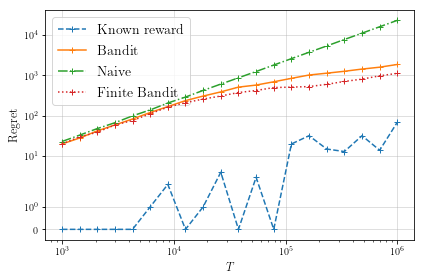

In [19]:
# plot evolution of regret
fig = plt.figure()
ls = ['--', '-', '-.', ':']
for i,algo in enumerate(algos[horizons[0]]):
    name = algonames.get(algo.name,algo.name)
    plt.plot(horizons, regret[algo.name], ls[i], label=name, marker='+')
plt.xlabel('$T$', fontsize=12)
plt.ylabel('Regret', fontsize=12)
plt.xscale('log')
plt.yscale('symlog')
plt.legend(fontsize=14, loc='upper left').set_zorder(1.5)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('figures/regret_{}_{}_{}_{}.pgf'.format(rew.name, ridedistribution.name, noise.name, expe))
plt.show()